In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from   datetime import timedelta
import datetime
import matplotlib as mpl
import glob
import os
from matplotlib import cm
import matplotlib.dates as mdates
from matplotlib import font_manager as fm
from matplotlib.ticker import ScalarFormatter, FormatStrFormatter
from mpl_toolkits.axes_grid1 import make_axes_locatable
import mat73
from pytides2.tide import Tide
import pytides2.constituent  as cons
import pytides2.astro as astro
from pyproj import Proj
import oceanlyz
import warnings
import matplotlib.pylab as pl
from scipy import signal
from os.path import dirname, join as pjoin
import scipy.io as sio
from netCDF4 import Dataset
from netCDF4 import num2date
from pytz import timezone
import pytz



warnings.filterwarnings('ignore')
plt.style.use('default')

import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cf
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

import seawater as sw

In [2]:
path_font=r"G:\My drive\TESIS_MAESTRIA_PAULAE\Fonts\Quicksand"

prop1 = fm.FontProperties(fname=path_font+'\Quicksand-Medium.ttf')
prop2 = fm.FontProperties(fname=path_font+'\Quicksand-SemiBold.ttf')
prop1.set_size(12)

In [3]:
# Funciones
def proj_ZONE17 (lon, lat):
    """
    Función para cambiar las proyecciones de las coordenadas:
    Input:
    lon, lat
    ----------------------------------------------------------
    Output:
    UTMX, UTMY
    """
    myProj = Proj("+proj=utm +zone=17 +ellps=WGS84 +datum=WGS84")
    UTMx, UTMy = myProj(lon, lat)
    return UTMx,UTMy

def coord_wgs (UTMx,UTMy):
    """
    Función para cambiar georeferenciar las proyecciones:
    Input:
    UTMX, UTMY
    ----------------------------------------------------------
    Output:
    lon, lat
    """
    myProj = Proj("+proj=utm +zone=17 +ellps=WGS84 +datum=WGS84")
    lon, lat = myProj(UTMx,UTMy, inverse = True)
    return 360 + lon, lat

# Importar datos

In [4]:
# Batimetría 
path = r'C:\Users\paula\Desktop\Bat_100m'
delta = 100
x = np.array ([414707.375 + i*delta for i in range(174)]) # Menor longitud, Numero de divisiones revisar archivo ASCI (output ARCGIS)
y = np.array ([1377008.875 + i*delta for i in range (191)])        # Menor Latitud,  Numero de divisiones revisar archivo ASCI (output ARCGIS)
z = np.flipud(np.genfromtxt(path+'\grid_depth.a',skip_header = 7))
z[z == -999] = np.nan # Z donde es tierra

# Suavizar la grilla
kernel = np.ones((1,1))/1.
z_smooth = signal.convolve2d(z, kernel, "same")
z_smooth = np.ma.masked_array(z, mask=np.isnan(z_smooth))
x_new = x.copy()
y_new = y.copy()
z_new = z_smooth.copy()

# Linea de costa data_dir = pjoin(dirname(sio.__file__), r"G:\My drive\TESIS_MAESTRIA_PAULAE\MODELO_NUMERICO\BATIMETRIA\Linea_COSTA_UTM") # Definir Ruta
data_dir = pjoin(dirname(sio.__file__), r"G:\My drive\TESIS_MAESTRIA_PAULAE\MODELO_NUMERICO\BATIMETRIA\Linea_COSTA_UTM") # Definir Ruta
mat_fname = pjoin(data_dir, 'linea_Costa.mat')     # Econtrar el archivo
data_mat = sio.loadmat(mat_fname)                 # Cargar el archivo
xlc, ylc = np.array(data_mat['data'][0][0][0]), np.array(data_mat['data'][0][0][1])
lc=np.column_stack((xlc,ylc))

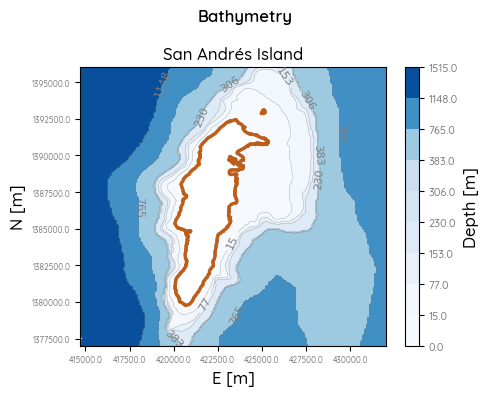

In [5]:
fig, ax = plt.subplots(figsize = (5,4))
colormap = cm.Blues
levels = list(np.round(np.nanmax(z_new)*np.array([0,1, 5, 10, 15, 20, 25, 50, 75, 99])/100,0))
pc = ax.contourf(x_new, y_new, z_new,levels = levels,cmap=colormap)
cb=plt.colorbar(pc)
a = ax.contour(x_new, y_new, z_new,colors="gray",levels=levels,\
                linewidths=0.2)
labels = plt.clabel(a, fontsize=8, inline=1, fmt = '%1.0f', colors="gray")
ax.set_xlabel ('E [m]',size=12,fontproperties=prop1)
ax.set_ylabel ('N [m]',size=12,fontproperties=prop1)
ax.plot(lc[:,0], lc[:,1], "-k", lw=2)
ax.set_xlim([x_new.min(), x_new.max()])
ax.set_ylim([y_new.min(), y_new.max()])
ax.xaxis.set_major_formatter(FormatStrFormatter('%.1f'))
ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
cb.set_label('Depth [m]',size=12,fontproperties=prop1)
cb.set_ticklabels(cb.get_ticks(), fontproperties=prop1, color='gray',size=8)
ax.set_yticklabels(ax.get_yticks(), fontproperties=prop1,color='gray',size = 6)
ax.set_xticklabels(ax.get_xticks(), fontproperties=prop1,color='gray',size = 6)
fig.suptitle("Bathymetry", size = 12,fontproperties=prop2)     # Titulo de la figura
ax.set_title('San Andrés Island',size = 12,fontproperties=prop1)   # Subtítulo de la figura
ax.plot(lc[:,0], lc[:,1], "-",c='chocolate', lw=2.5, alpha = 0.9)

fig.tight_layout()
# plt.xticks(rotation = 20)
plt.grid(False)

# Layer thickness

In [6]:
thickness = np.array([0.05, 0.8, 1.6, 2, 3, 3.7, 5.2, 12.4, 33.45, 37.8])*np.nanmax(z)/100

# Condiciones de frontera

In [7]:
path = r"G:\My drive\TESIS_MAESTRIA_PAULAE\MODELO_NUMERICO\BATIMETRIA\BAT_200m"
delta = 200                                           # Tamaño de la grilla 
x = np.array ([404758.9787 + i*delta for i in range(203)]) # Menor longitud, Numero de divisiones revisar archivo ASCI (output ARCGIS)
y = np.array ([1368354.4849 + i*delta for i in range (208)])        # Menor Latitud,  Numero de divisiones revisar archivo ASCI (output ARCGIS)
z = np.flipud(np.genfromtxt(path+'\idw_200m.txt',skip_header = 6))
z[z == -9999] = np.nan # Z donde es tierra

In [8]:
def min_ind (value, vector, delta):
    indices = np.where((vector > value-(delta)) & (vector < value+(delta)))[0]
    for i in indices: 
        try :
            if vector[i] - value < vector[i+1] - value:
                ind = i
            else:
                ind = i+1
        except:
            print('**********ERROR************')
    print('Indice:',ind,', Valor:', vector[ind], ', Valor real:', value)

    return ind

In [9]:
# Match whit big grid (200m)
x_min, x_max = np.min(x_new), np.max(x_new)
y_min, y_max = np.min(y_new), np.max(y_new)

indx_min, indx_max = min_ind(value = x_min, vector= x, delta = 200 ), min_ind(value = x_max, vector= x, delta = 200 )
indy_min, indy_max = min_ind(value = y_min, vector= y, delta = 200 ), min_ind(value = y_max, vector= y, delta = 200 )

Indice: 50 , Valor: 414758.9787 , Valor real: 414707.375
Indice: 137 , Valor: 432158.9787 , Valor real: 432007.375
Indice: 44 , Valor: 1377154.4849 , Valor real: 1377008.875
Indice: 139 , Valor: 1396154.4849 , Valor real: 1396008.875


In [10]:
def load_mat_files(path):
    """
    INPUTS: 
    - path: path of file
    ------------------------------------------------------------------------
    OUTPUT:
    - Dictionary of data
    """
    # path = 'G:\My Drive\TESIS_MAESTRIA_PAULAE\MODELO_NUMERICO\CODIGOS'
    prop_mat_data = mat73.loadmat(path)
    dic_data = prop_mat_data['data']
    return dic_data

In [11]:
paths_vel = glob.glob(r"C:\Users\paula\Desktop\TEST14_NESTED\vel*.mat")
paths_wl = glob.glob(r"C:\Users\paula\Desktop\TEST14_NESTED\water*.mat")

In [12]:
# Time
py_datetime = [datetime.datetime.fromordinal(int(i)) + timedelta(days=i%1) - timedelta(days = 366) for i in load_mat_files(paths_vel[0])['Time']]
time_df = [datetime.datetime(i.year, i.month, i.day, i.hour, i.minute, i.second) for i in py_datetime]
minutes = np.array([((time_df[i] - time_df[0]).days*1440)+((time_df[i] - time_df[0]).seconds/60) for i in range (0,len(time_df))])


$f(t)=U+\zeta\sqrt{\frac{g}{d}}$

where $U$ in m/s is depth-averaged velocity in $x$ or ξ direction, $\zeta$ in m is water level above some horizontal plane of reference (datum),  $d$ an $g$ are depth below some horizontal plane of reference (datum) and acceleration due to gravity in m and m/s respectively.

In [13]:
def riemman(u, wl, depth_s, depth_vector):
    """
    Input:
    u:  Velcidad en la coordenada u
    wl: nivel del agua
    depth_s: profundidad de la velocidad u
    depth_vector: profundidades consideradas
    ------------------------------------------------
    Salida:
    ft: función de riemman para la profunidad considerada
    
    """
    g = 9.81
    u_mean = np.nanmean(u[:,np.where(depth_vector == depth_s)[0][0]:], axis= 1)
    ft = u_mean +wl*(np.sqrt(g/depth_s))
    return ft

def dic_rieman(name1):
    dic = {}
    for i, j in zip (paths_vel, paths_wl):
        if (name1 in i)==True:
            print(i,j)
            vel = load_mat_files(i)['Val']
            ws = load_mat_files(j)['Val']
            depth_vector = -load_mat_files(i)['Z'][0]
            for m, h in enumerate(depth_vector):
                ft = riemman(u=vel, wl=ws,depth_s=h, depth_vector=depth_vector)
                if ('A_' in name1) == True:
                    dic.update({m:ft})
                elif ('B_' in name1) == True:
                    dic.update({10+m:ft})
        else:
            pass
    return dic

In [14]:
def dic_rieman(name1):
    dic = {}
    for i, j in zip (paths_vel, paths_wl):
        if (name1 in i)==True:
            print(i,j)
            vel = load_mat_files(i)['Val']
            ws = load_mat_files(j)['Val']
            depth_vector = -load_mat_files(i)['Z'][0]
            for m, h in enumerate(depth_vector):
                ft = riemman(u=vel, wl=ws,depth_s=h, depth_vector=depth_vector)
                if ('A_' in name1) == True:
                    dic.update({m:ft})
                elif ('B_' in name1) == True:
                    dic.update({10+m:ft})
        else:
            pass
    return dic

In [15]:
#-------------Frontera Este--------------------------------------
dic_east = dic_rieman('A_East')
dic_east.update(dic_rieman('B_East'))
df_east = pd.DataFrame(dic_east)
df_east.insert(loc= 0, column = 'minutes', value = minutes)

path =  r"G:\My drive\TESIS_MAESTRIA_PAULAE\MODELO_NUMERICO\CODIGOS"
name_file = 'east_boundary.bct'
np.savetxt(path+'/'+name_file, df_east.values, delimiter=' ', fmt = "%+15.7e")

C:\Users\paula\Desktop\TEST14_NESTED\velocity_A_East.mat C:\Users\paula\Desktop\TEST14_NESTED\water_level_A_East.mat
C:\Users\paula\Desktop\TEST14_NESTED\velocity_B_East.mat C:\Users\paula\Desktop\TEST14_NESTED\water_level_B_East.mat


In [16]:
#-------------Frontera Oeste--------------------------------------
dic_west = dic_rieman('A_West')
dic_west.update(dic_rieman('B_West'))
df_west = pd.DataFrame(dic_west)
df_west.insert(loc= 0, column = 'minutes', value = minutes)

path =  r"G:\My drive\TESIS_MAESTRIA_PAULAE\MODELO_NUMERICO\CODIGOS"
name_file = 'west_boundary.bct'
np.savetxt(path+'/'+name_file, df_west.values, delimiter=' ', fmt = "%+15.7e")

C:\Users\paula\Desktop\TEST14_NESTED\velocity_A_West.mat C:\Users\paula\Desktop\TEST14_NESTED\water_level_A_West.mat
C:\Users\paula\Desktop\TEST14_NESTED\velocity_B_West.mat C:\Users\paula\Desktop\TEST14_NESTED\water_level_B_West.mat


In [17]:
#-------------Frontera Norte--------------------------------------
dic_north = dic_rieman('A_North')
dic_north.update(dic_rieman('B_North'))
df_north = pd.DataFrame(dic_north)
df_north.insert(loc= 0, column = 'minutes', value = minutes)

path =  r"G:\My drive\TESIS_MAESTRIA_PAULAE\MODELO_NUMERICO\CODIGOS"
name_file = 'north_boundary.bct'
np.savetxt(path+'/'+name_file, df_north.values, delimiter=' ', fmt = "%+15.7e")

C:\Users\paula\Desktop\TEST14_NESTED\velocity_A_North.mat C:\Users\paula\Desktop\TEST14_NESTED\water_level_A_North.mat
C:\Users\paula\Desktop\TEST14_NESTED\velocity_B_North.mat C:\Users\paula\Desktop\TEST14_NESTED\water_level_B_North.mat


In [18]:
#-------------Frontera Sur--------------------------------------
dic_south = dic_rieman('A_South')
dic_south.update(dic_rieman('B_South'))
df_south = pd.DataFrame(dic_south)
df_south.insert(loc= 0, column = 'minutes', value = minutes)

path =  r"G:\My drive\TESIS_MAESTRIA_PAULAE\MODELO_NUMERICO\CODIGOS"
name_file = 'south_north.bct'
np.savetxt(path+'/'+name_file, df_south.values, delimiter=' ', fmt = "%+15.7e")

C:\Users\paula\Desktop\TEST14_NESTED\velocity_A_South.mat C:\Users\paula\Desktop\TEST14_NESTED\water_level_A_South.mat
C:\Users\paula\Desktop\TEST14_NESTED\velocity_B_South.mat C:\Users\paula\Desktop\TEST14_NESTED\water_level_B_South.mat


# Constitutivas

In [19]:
path =  r"G:\My drive\TESIS_MAESTRIA_PAULAE\MODELO_NUMERICO\CODIGOS"
data_prop = Dataset(path+'\Hycom_oct21_nov15_2021_6_temp_sal_2.nc','r')
#-------Metadatos-------------------------------------------
lat = np.array(data_prop.variables['latitude'][:])
lon = np.array(data_prop.variables['longitude'][:])
nctime = np.array(data_prop.variables['time'][:])
t_unit = data_prop.variables['time'].units
t_cal = data_prop.variables['time'].calendar
time = num2date(nctime,units=t_unit,calendar=t_cal)#Date time
time_str = np.array([time[i].strftime("%Y-%m-%d %H:%M:%S") for i in range (len(time))])
time = np.array([datetime.datetime.strptime(time_str[i], "%Y-%m-%d %H:%M:%S") for i in range (len(time))])

#------ Cambiar referencia de tiempo a utm-----------------------------------
# Cambiar la zona horaria utc 0 a utc -5
utc = pytz.utc
col_zone = timezone('America/Bogota')
time2=np.array([datetime.datetime(i.year,i.month,i.day,i.hour,i.minute,tzinfo=utc) for i in time])
loc_co =np.array([i.astimezone(col_zone) for i in time2])
time = np.array([datetime.datetime(i.year,i.month,i.day,i.hour,i.minute) for i in loc_co])

#---------------------Variables------------------------------------------------
salt = np.array(data_prop.variables['salinity'][:])
salt[salt==-30000] = np.nan
temp = np.array(data_prop.variables['water_temp'][:])
temp[temp==-30000] = np.nan
depth =  np.array(data_prop.variables['depth'][:])

In [20]:
# Profunidades de acuerdo con los espersores del modelo
depth_model = np.cumsum(thickness)

# Profundidades de los datos de reanálisis que hacen más match con los del modelo 
depth_layer = [0, 12, 40, 70, 125, 200, 300, 400, 1000, 1500]

In [21]:
def constituten(c, depth_s, depth_bd, lat_s, lat_bd, lon_s, lon_bd):
    """
    ------------input------------------------
    c: arreglo de la propiedad constitutiva (temp / sal) 
    depth_s: serie de profundidades 
    lat_bd: Cordenanda latitud 
    lon_bd: Coordenada longitud
    lat_s: serie de latitud 
    lon_s: Serie de longitud
    
    ------------output----------------------------
    constituen: serie de la propiedad constitutiva a la profundida deseada
    
    """
    c= c[:,np.where(depth_s==depth_bd)[0][0], np.where(lat_s==lat_bd)[0][0],np.where(lon_s == lon_bd)[0][0]]
    return c

In [22]:
# Time split
date_ini = datetime.datetime(2021,11,2,1) # Fechas inicial de modelación
date_fin = datetime.datetime(2021,11,14,16,0) # Fechas final de modelación
ind_ini_fin = np.where((time==date_ini)|(time==date_fin))[0]
time_d3d = time[ind_ini_fin[0]:ind_ini_fin[1]]
minutes = np.array([((time_d3d[i] - time_d3d[0]).days*1440)+((time_d3d[i] - time_d3d[0]).seconds/60) for i in range (0,len(time_d3d))])

# Time split of variables
temp_split = salt[ind_ini_fin[0]:ind_ini_fin[1],:,:]
temp_split = temp[ind_ini_fin[0]:ind_ini_fin[1],:,:]

In [23]:
# Este
#------------------A---------------------------
lat_bd = 12.479999542236328
lon_bd = 278.4000244140625
dic_sal = {}
for j, h in enumerate (depth_layer):
    c = constituten(temp_split, depth, h, lat, lat_bd, lon,lon_bd)
    dic_sal.update({j:c})


#-----------------B-------------------------------
lat_bd = 12.600000381469727
lon_bd = 278.4000244140625
for j, h in enumerate (depth_layer):
    c = constituten(temp_split, depth, h, lat, lat_bd, lon,lon_bd)
    dic_sal.update({10+j:c})

df_sal_este = pd.DataFrame(dic_sal)
df_sal_este.insert(loc= 0, column = 'minutes', value = minutes)

path =  r"G:\My drive\TESIS_MAESTRIA_PAULAE\MODELO_NUMERICO\CODIGOS"
name_file = 'salt_este_boundary.bcc'
np.savetxt(path+'/'+name_file, df_sal_este.values, delimiter=' ', fmt = "%+15.7e")

In [24]:
dic_temp = {}
for j, h in enumerate (depth_layer):
    c = constituten(temp_split, depth, h, lat, lat_bd, lon,lon_bd)
    dic_temp.update({j:c})

for j, h in enumerate (depth_layer):
    c = constituten(temp_split, depth, h, lat, lat_bd, lon,lon_bd)
    dic_temp.update({10+j:c})

df_temp_este = pd.DataFrame(dic_temp)
df_temp_este.insert(loc= 0, column = 'minutes', value = minutes)

name_file = 'temp_este_boundary.bcc'
np.savetxt(path+'/'+name_file, df_temp_este.values, delimiter=' ', fmt = "%+15.7e")


In [25]:
# Oeste
#------------------A---------------------------
lat_bd = 12.479999542236328
lon_bd = 278.1600341796875
for j, h in enumerate (depth_layer):
    c = constituten(temp_split, depth, h, lat, lat_bd, lon,lon_bd)
    dic_sal.update({j:c})

#-----------------B-------------------------------
lat_bd = 12.600000381469727
lon_bd = 278.1600341796875
for j, h in enumerate (depth_layer):
    c = constituten(temp_split, depth, h, lat, lat_bd, lon,lon_bd)
    dic_sal.update({10+j:c})

df_sal_oeste = pd.DataFrame(dic_sal)
df_sal_oeste.insert(loc= 0, column = 'minutes', value = minutes)

path =  r"G:\My drive\TESIS_MAESTRIA_PAULAE\MODELO_NUMERICO\CODIGOS"
name_file = 'salt_oeste_boundary.bcc'
np.savetxt(path+'/'+name_file, df_sal_oeste.values, delimiter=' ', fmt = "%+15.7e")

In [26]:
dic_temp = {}
for j, h in enumerate (depth_layer):
    c = constituten(temp_split, depth, h, lat, lat_bd, lon,lon_bd)
    dic_temp.update({j:c})

for j, h in enumerate (depth_layer):
    c = constituten(temp_split, depth, h, lat, lat_bd, lon,lon_bd)
    dic_temp.update({10+j:c})

df_temp_oeste = pd.DataFrame(dic_temp)
df_temp_oeste.insert(loc= 0, column = 'minutes', value = minutes)

name_file = 'temp_oeste_boundary.bcc'
np.savetxt(path+'/'+name_file, df_temp_oeste.values, delimiter=' ', fmt = "%+15.7e")

In [27]:
# Sur
#-----------------A---------------------------------
lat_bd = 12.4399995803833
lon_bd = 278.1600341796875
for j, h in enumerate (depth_layer):
    c = constituten(temp_split, depth, h, lat, lat_bd, lon,lon_bd)
    dic_sal.update({j:c})

#----------------B------------------------------------
lat_bd = 12.4399995803833
lon_bd = 278.4000244140625
for j, h in enumerate (depth_layer):
    c = constituten(temp_split, depth, h, lat, lat_bd, lon,lon_bd)
    dic_sal.update({10+j:c})

df_sal_sur = pd.DataFrame(dic_sal)
df_sal_sur.insert(loc= 0, column = 'minutes', value = minutes)

path =  r"G:\My drive\TESIS_MAESTRIA_PAULAE\MODELO_NUMERICO\CODIGOS"
name_file = 'salt_sur_boundary.bcc'
np.savetxt(path+'/'+name_file, df_sal_sur.values, delimiter=' ', fmt = "%+15.7e")

In [28]:
dic_temp = {}
for j, h in enumerate (depth_layer):
    c = constituten(temp_split, depth, h, lat, lat_bd, lon,lon_bd)
    dic_temp.update({j:c})

for j, h in enumerate (depth_layer):
    c = constituten(temp_split, depth, h, lat, lat_bd, lon,lon_bd)
    dic_temp.update({10+j:c})

df_temp_sur = pd.DataFrame(dic_temp)
df_temp_sur.insert(loc= 0, column = 'minutes', value = minutes)

name_file = 'temp_sur_boundary.bcc'
np.savetxt(path+'/'+name_file, df_temp_sur.values, delimiter=' ', fmt = "%+15.7e")

In [29]:
# North
#---------A------------------
lat_bd = 12.640000343322754
lon_bd = 278.1600341796875
dic_sal = {}
for j, h in enumerate (depth_layer):
    c = constituten(temp_split, depth, h, lat, lat_bd, lon,lon_bd)
    dic_sal.update({j:c})


#---------B------------------
lat_bd = 12.640000343322754
lon_bd = 278.4000244140625
for j, h in enumerate (depth_layer):
    c = constituten(temp_split, depth, h, lat, lat_bd, lon,lon_bd)
    dic_sal.update({10+j:c})

df_sal_norte = pd.DataFrame(dic_sal)
df_sal_norte.insert(loc= 0, column = 'minutes', value = minutes)

path =  r"G:\My drive\TESIS_MAESTRIA_PAULAE\MODELO_NUMERICO\CODIGOS"
name_file = 'salt_norte_boundary.bcc'
np.savetxt(path+'/'+name_file, df_sal_norte.values, delimiter=' ', fmt = "%+15.7e")


In [40]:
dic_temp = {}
for j, h in enumerate (depth_layer):
    c = constituten(temp_split, depth, h, lat, lat_bd, lon,lon_bd)
    dic_temp.update({j:c})

for j, h in enumerate (depth_layer):
    c = constituten(temp_split, depth, h, lat, lat_bd, lon,lon_bd)
    dic_temp.update({10+j:c})

df_temp_norte = pd.DataFrame(dic_temp)
df_temp_norte.insert(loc= 0, column = 'minutes', value = minutes)

name_file = 'temp_norte_boundary.bcc'
np.savetxt(path+'/'+name_file, df_temp_norte.values, delimiter=' ', fmt = "%+15.7e")

# Oleaje 

In [50]:
x_norte_sur = [x_min+5800, x_min + 11600]
y_este_oeste = [y_min, y_min + 6333, y_min + 12667, y_max]
print(x_norte_sur, y_este_oeste)

[420507.375, 426307.375] [1377008.875, 1383341.875, 1389675.875, 1396008.875]


In [55]:
def min_ind (value, vector, delta):
    indices = np.where((vector > value-(delta)) & (vector < value+(delta)))[0]
    for i in indices: 
        try :
            if abs(vector[i] - value) < abs(vector[i+1] - value):
                ind = i
            else:
                ind = i+1
        except:
            print('**********ERROR************')
    print('Indice:',ind,', Valor:', vector[ind], ', Valor real:', value)

    return ind

In [56]:
in_norte_sur = [min_ind(value= j, vector= x, delta =200) for j in x_norte_sur]
in_este_oeste = [min_ind(value= j, vector= y, delta =200) for j in y_este_oeste]

Indice: 79 , Valor: 420558.9787 , Valor real: 420507.375
Indice: 108 , Valor: 426358.9787 , Valor real: 426307.375
Indice: 44 , Valor: 1377154.4849 , Valor real: 1377008.875
Indice: 75 , Valor: 1383354.4849 , Valor real: 1383341.875
Indice: 107 , Valor: 1389754.4849 , Valor real: 1389675.875
Indice: 139 , Valor: 1396154.4849 , Valor real: 1396008.875


In [57]:
print(indx_max, indx_min)
print(indy_max, indy_min)

137 50
139 44
